<a href="https://colab.research.google.com/github/KatherineElkins/programming-humanity-2025/blob/main/axelrod_model_11012025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Axelrod Model of Dissemination of Culture

We are going to simulate the Axelrod model of dissemination of culture from his paper titled "The Dissemination of Culture: A Model with Local Convergence and Global Polarization" (https://journals.sagepub.com/doi/10.1177/0022002797041002001).

In this simulation, we will use the agent-based framework in python provided by the Mesa framework (https://mesa.readthedocs.io/en/stable/).

We modify the model to use randomly generated network instead of the standard square grid here.

After running the simulation, we present the plot that measures trait differences between neighbors for the entire system.

**Updated for Mesa 3.x compatibility by K Elkins November 2025**

## Model Summary

Consider each person to have $n$ number of cultural features we call as $feature$ that could be represented as political leaning, economic stance, fashion, favorite music, etc. Each of this feature could be classified into $m$ number of traits, for example in economic stance there are possible traits such as marxian, keynesian, etc. They are connected to each other as nodes in a network $G$, where they can only interact with their neighbors.

For each time step:
1. Pick a random agent in the network and one of its neighbor.
2. Measure their feature similarities, and calculate the probability of interaction based on $P = \frac{\text{no. same features}}{n}$.
3. If they decide to interact based on the probability, the agent will adopt the neighbor's trait for a random feature where they differ in value (if any).

Based on these simple rules, we will observe how homogenization is achieved over time.

## Install Mesa

In [1]:
!pip install mesa matplotlib networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 4.0 MB/s eta 0:00:00


## Imports

In [2]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

## Defining the Agent and the Model

We will define the agent and the object model according to Mesa's framework. In this implementation, the action is done under the model's step instead of agent's step because it is simpler to just call one agent at a time using this interaction, as the usual Mesa scheduler requires every agent to be activated in each time step.

In [3]:
class AxelrodAgent(Agent):
    """Individual agent represented by a node in a network"""

    def __init__(self, model, node_id, feat, trt):
        """Initialize agent with random cultural features"""
        super().__init__(model)
        self.node_id = node_id  # Store the network node ID
        self.feature = np.random.randint(low=0, high=trt, size=feat)

    def step(self):
        """Agent step - not used in this model"""
        pass


class AxelrodModel(Model):
    """Model containing N agents connected in a network"""

    def __init__(self, N, Graph, feat, trt):
        """Initialize the model with agents on a network"""
        super().__init__()
        self.graph = Graph
        self.no_features = feat
        self.no_agents = N
        self.G = NetworkGrid(Graph)

        # Creating the agents - Mesa 3.x handles unique_id automatically
        # We need to track node_id separately for network navigation
        for i in range(self.no_agents):
            a = AxelrodAgent(self, i, feat, trt)
            self.G.place_agent(a, i)  # Place agent on network node i

        # Creating collector for difference function
        self.datacollector = DataCollector(
            model_reporters={"Difference": self.calculate_difference}
        )

    def calculate_difference(self):
        """Calculate the average feature difference across all edges in the network"""
        diff = 0
        conn = nx.edges(self.graph)

        # Create a dictionary mapping node_id to agent
        node_to_agent = {agent.node_id: agent for agent in self.agents}

        edge_count = 0
        for edge in conn:
            if edge[0] in node_to_agent and edge[1] in node_to_agent:
                agent1 = node_to_agent[edge[0]]
                agent2 = node_to_agent[edge[1]]
                diff += np.mean(np.abs(agent1.feature - agent2.feature))
                edge_count += 1

        return diff if edge_count == 0 else diff

    def step(self):
        """Execute one step of the model"""
        self.datacollector.collect(self)

        # Create agent list
        agent_list = list(self.agents)
        if len(agent_list) == 0:
            return

        # Select random agent
        agent = self.random.choice(agent_list)

        # Get neighbor agents directly (NetworkGrid returns agents in Mesa 3.x)
        neighbors = self.G.get_neighbors(agent.node_id)

        if len(neighbors) > 0:
            # Select random neighbor (it's already an agent object)
            neigh = self.random.choice(neighbors)

            # Calculate interaction probability based on similarity
            diff = agent.feature - neigh.feature
            prob = np.count_nonzero(diff) / self.no_features

            # Interact with probability proportional to differences
            if self.random.random() < prob:
                # Find features where they differ
                diff_indices = np.nonzero(diff)[0]
                if len(diff_indices) > 0:
                    # Randomly select one differing feature and adopt neighbor's trait
                    index = self.random.choice(diff_indices)
                    agent.feature[index] = neigh.feature[index]

## Running the Model

Below are the values required to initialize the model. We use networkx to generate a random network.

Feel free to experiment with the parameters.

In [4]:
# Model parameters
features = 5      # Number of cultural features per agent
traits = 5        # Number of possible values for each feature
N = 50            # Number of agents
P = 0.1           # Probability of edge in random graph
steps = 10000     # Number of simulation steps

# Generate random graph
G = nx.erdos_renyi_graph(N, P)

print(f"Graph properties:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

Graph properties:
  Nodes: 50
  Edges: 126
  Average degree: 5.04


In [5]:
# Initialize and run the model
model = AxelrodModel(N, G, features, traits)

print(f"Running model for {steps} steps...")
for i in range(steps):
    model.step()
    if (i + 1) % 1000 == 0:
        print(f"  Step {i + 1}/{steps}")

print("Simulation complete!")

Running model for 10000 steps...
  Step 1000/10000
  Step 2000/10000
  Step 3000/10000
  Step 4000/10000
  Step 5000/10000
  Step 6000/10000
  Step 7000/10000
  Step 8000/10000
  Step 9000/10000
  Step 10000/10000
Simulation complete!


## Plotting Results

Let's visualize how the cultural differences evolved over time.

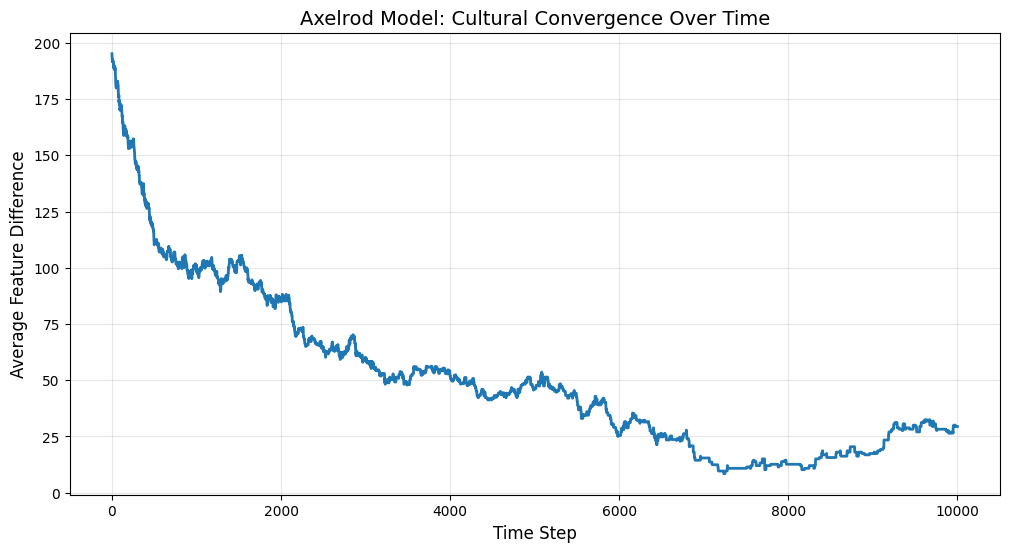


Final average difference: 29.4000
Initial average difference: 195.2000
Reduction: 84.9%


In [6]:
# Get the data
data = model.datacollector.get_model_vars_dataframe()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data['Difference'], linewidth=2)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Feature Difference', fontsize=12)
plt.title('Axelrod Model: Cultural Convergence Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal average difference: {data['Difference'].iloc[-1]:.4f}")
print(f"Initial average difference: {data['Difference'].iloc[0]:.4f}")
if data['Difference'].iloc[0] > 0:
    print(f"Reduction: {(1 - data['Difference'].iloc[-1]/data['Difference'].iloc[0])*100:.1f}%")

## Visualize Final Network State

Let's visualize the network with nodes colored by their cultural similarity.

/tmp/ipython-input-2876374618.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


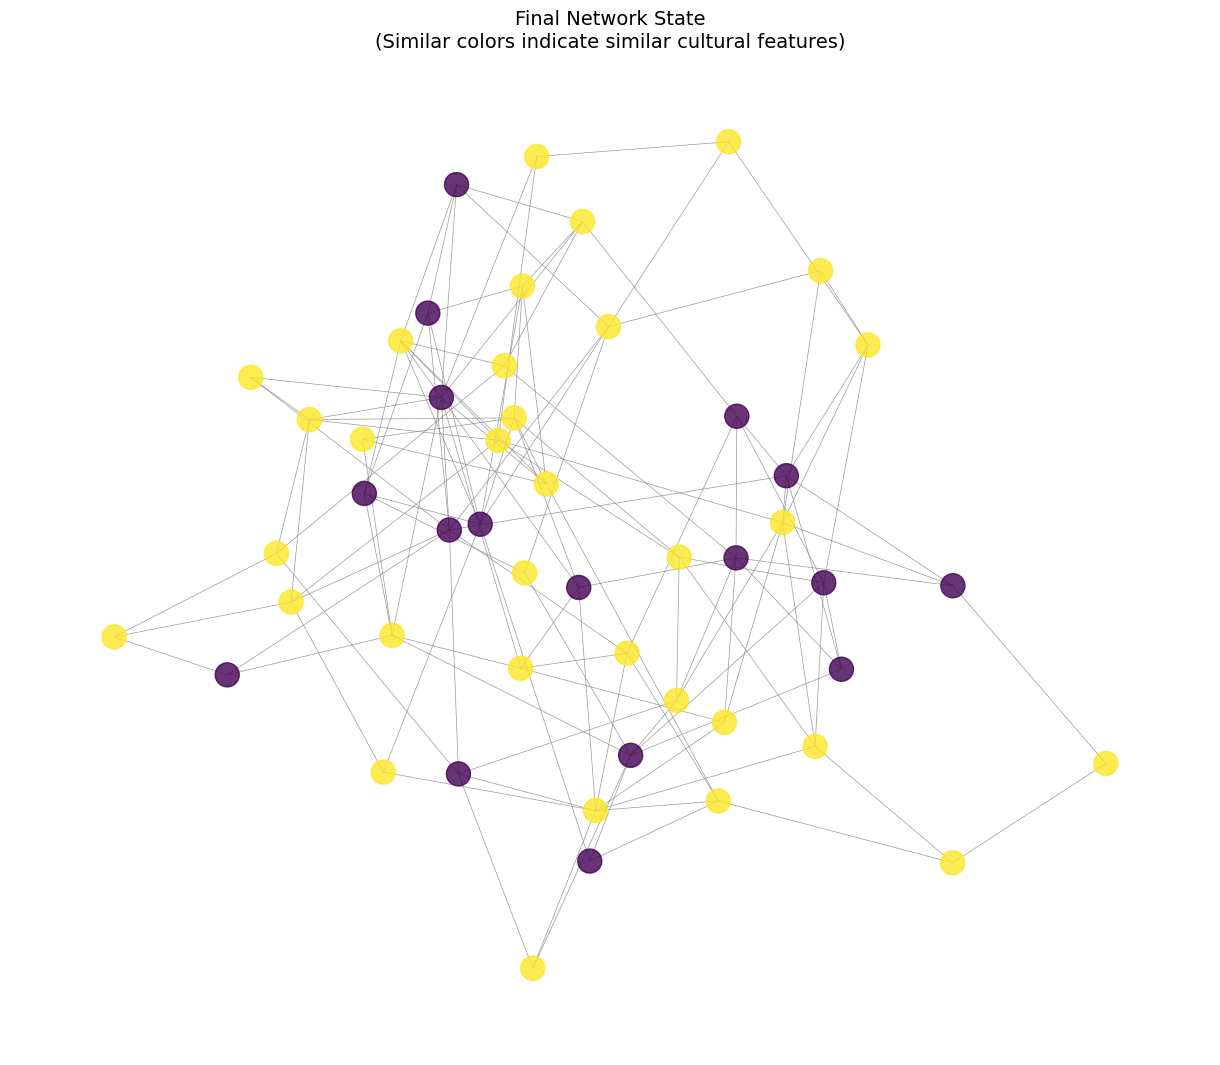

In [7]:
# Create a simple hash of each agent's features for coloring
node_to_agent = {agent.node_id: agent for agent in model.agents}
colors = []

for node in G.nodes():
    if node in node_to_agent:
        # Use tuple of features as a simple identifier
        feature_tuple = tuple(node_to_agent[node].feature)
        colors.append(hash(feature_tuple))
    else:
        colors.append(0)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=colors, node_size=300,
        cmap='viridis', with_labels=False, alpha=0.8,
        edge_color='gray', width=0.5)
plt.title('Final Network State\n(Similar colors indicate similar cultural features)',
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## Analysis

The Axelrod model demonstrates how local interactions can lead to:
- **Convergence**: Nearby agents become more similar over time
- **Polarization**: Distinct cultural regions can form and persist

The key insight is that agents are more likely to interact (and become similar) when they already share some cultural features, but once they become too different, interaction stops, leading to stable cultural boundaries.